In [3]:
import sys

sys.path.insert(1, '../..')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from functions.other_functions import process_date, process_exposure, chi2, linear
import random
from tqdm import tqdm_notebook
%matplotlib inline 

In [5]:
def model(t, p0, p1, p2):
    y = []
    for i in range(len(t)):
        temp = 0
        for n in range(1,11):
            temp += ((-1)**n/n**2)*(1 - np.exp(-(n**2)*(np.pi**2)*t[i]/p1))
        f2 = (2/np.pi**2)*p1*temp
        y.append(p0*(t[i] + f2) + p2)
    return y

In [6]:
def model_day(x, p0, p1, p2):
    y = []
    for i in range(len(x)):
        t = x[i]*3600*24
        temp = 0
        for n in range(1,11):
            temp += ((-1)**n/n**2)*(1 - np.exp(-(n**2)*(np.pi**2)*t/p1))
        f2 = (2/np.pi**2)*p1*temp
        y.append(p0*(t + f2) + p2)
    return y

In [7]:
def linear_days(x, m, c):
    return m*x*3600*24 + c

In [8]:
def residual(y_obs, y_expected, y_err):
    return ((y_obs - y_expected)/y_err)

In [9]:
data_ch0 = np.loadtxt('/Users/willquinn/Desktop/pmt_output_files/apulse_num_ch0.txt', delimiter=',', unpack=True)
date = np.array(process_date(data_ch0[0]))
exposure = np.array(process_exposure(data_ch0[0]))
apulse_rates = data_ch0[1]
apulse_rates_err = data_ch0[2]
he_apulse_rates = data_ch0[3]
he_apulse_rates_err = data_ch0[4]

try:
    start = np.where(date == 0)[0][-1]
except:
    start = np.where(date == 1)[0][0]
mid = np.where(date == 98)[0][0]
date_days = date - 98
date = (date - 98)*24*60*60

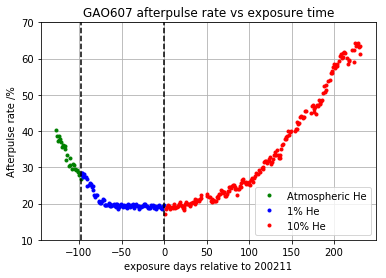

In [10]:
plt.plot(date_days[:start + 1], np.array(apulse_rates[:start + 1]),
                 "g.", label="Atmospheric He")
plt.plot(date_days[start+1:mid + 1], np.array(apulse_rates[start+1:mid + 1]),
                 "b.", label="1% He")
plt.plot(date_days[mid+1:], np.array(apulse_rates[mid+1:]),
                 "r.", label="10% He")
plt.axvline(date_days[start], 0, 100, ls='--', color='k')
plt.axvline(date_days[mid], 0, 100, ls='--', color='k')
plt.xlabel("exposure days relative to 200211")
plt.ylabel("Afterpulse rate /%")
plt.title("GAO607 afterpulse rate vs exposure time")
plt.grid()
plt.ylim(10,70)
plt.legend(loc='lower right')

In [11]:

#print(date[mid:], apulse_rates[mid:], apulse_rates_err[mid:])

In [12]:
chi_2 = 100
n_times = 1
n = 0
for n in tqdm_notebook(range(n_times)):
    p_bounds = [[0,0,18],[1e5,1e10,20]]
    '''p0 = random.uniform(p_bounds[0][0],p_bounds[1][0])
    p1 = random.uniform(p_bounds[0][1],p_bounds[1][1])
    p2 = random.uniform(p_bounds[0][2],p_bounds[1][2])
    p3 = random.uniform(p_bounds[0][3],p_bounds[1][3])
    p4 = random.uniform(p_bounds[0][4],p_bounds[1][4])'''
    p0 = 0.1
    p1 = 1
    p2 = 19
    p_guess = [p0, p1, p2]
    
    popt, pcov = curve_fit(model, date[mid+1:], apulse_rates[mid+1:], sigma=apulse_rates_err[mid+1:], p0=p_guess,
                           bounds=p_bounds)
    chi_2 = chi2(apulse_rates[mid+1:], apulse_rates_err[mid+1:], model(date[mid+1:], *popt), len(popt))
   
    if chi_2 < 1:
        break


print('Param p{}: {:.8f} ± {:.8f}'.format(0, popt[0], np.sqrt(pcov[0,0])))
print('Param p{}: {:.9f} ± {:.9f}'.format(1, popt[1], np.sqrt(pcov[1,1])))
print('Param p{}: {:.1f} ± {:.1f}'.format(2, popt[2], np.sqrt(pcov[2,2])))
print('Chi2 is:', chi_2)


Param p0: 0.00000442 ± 0.00000003
Param p1: 60120178.693628125 ± 0.000000005
Param p2: 19.7 ± 0.1
Chi2 is: 0.048833633355669905


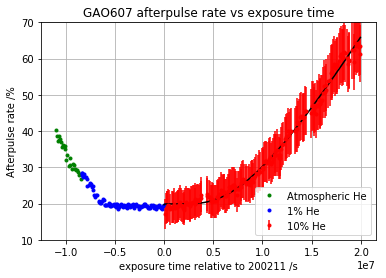

In [13]:
plt.plot(date[:start + 1], np.array(apulse_rates[:start + 1]),
                 "g.", label="Atmospheric He")
plt.plot(date[start+1:mid + 1], np.array(apulse_rates[start+1:mid + 1]),
                 "b.", label="1% He")
plt.errorbar(date[mid+1:], np.array(apulse_rates[mid+1:]), yerr=np.array(apulse_rates_err[mid+1:]),
                 fmt="r.", label="10% He")
x_range = np.linspace(0,date[-1],1000)
plt.plot(x_range, model(x_range, *popt), 'k')
#plt.axvline(date[start], 0, 100, ls='--', color='k')
#plt.axvline(date[mid], 0, 100, ls='--', color='k')
plt.xlabel("exposure time relative to 200211 /s")
plt.ylabel("Afterpulse rate /%")
plt.title("GAO607 afterpulse rate vs exposure time")
plt.grid()
plt.ylim(10,70)
plt.legend(loc='lower right')
plt.savefig("/Users/willquinn/Desktop/pmt_output_files/summary_plots/model.png")

$C_g(t) = P_0 ( t + \frac{2}{\pi^2}P_1\sum^{10}_{n=1}\frac{(-1)^n}{n^2}(1 - e^{\frac{-n^2\pi^2t}{P_1}}) + P_2$

$P_0 = \frac{C_2D}{lV}$, $P_1 = \frac{l^2}{D} = 6L$

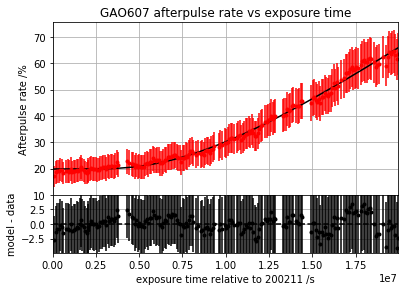

In [14]:
#PLOT
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.errorbar(date[mid+1:], np.array(apulse_rates[mid+1:]), yerr=np.array(apulse_rates_err[mid+1:]),
                 fmt="r.", label="10% He")
plt.plot(x_range, model(x_range, *popt), 'k')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.xlim(0,date[-1])
plt.grid()
plt.ylabel("Afterpulse rate /%")
plt.title("GAO607 afterpulse rate vs exposure time")

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
'''plt.plot(date[mid+1:], residual(np.array(apulse_rates[mid+1:]),
                                model(date[mid+1:], *popt),
                                np.array(apulse_rates_err[mid+1:])), 'k.')'''
plt.errorbar(date[mid+1:], np.array(apulse_rates[mid+1:])- model(date[mid+1:], *popt),
                                yerr=np.array(apulse_rates_err[mid+1:]), fmt='k.')
plt.ylim(-4.9,4.9)
plt.xlim(0,date[-1])
plt.axhline(0,ls='--', color='k')
plt.grid()
plt.ylabel("model - data")
plt.xlabel("exposure time relative to 200211 /s")

plt.savefig("/Users/willquinn/Desktop/pmt_output_files/summary_plots/model_residual.png")

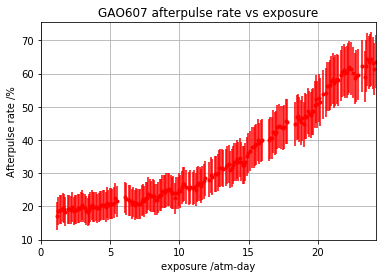

In [15]:
'''#PLOT
x_range_exp = np.linspace(0,exposure[-1],1000)
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))'''
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.errorbar(exposure[mid+1:], np.array(apulse_rates[mid+1:]), yerr=np.array(apulse_rates_err[mid+1:]),
                 fmt="r.", label="10% He")
#plt.plot(x_range_exp, model(x_range_exp, *popt), 'k')
#frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.xlim(0,exposure[-1])
plt.grid()
plt.ylabel("Afterpulse rate /%")
plt.title("GAO607 afterpulse rate vs exposure")

#Residual plot
'''frame2=fig1.add_axes((.1,.1,.8,.2))
plt.plot(date[mid+1:], residual(np.array(apulse_rates[mid+1:]),
                                model(date[mid+1:], *popt),
                                np.array(apulse_rates_err[mid+1:])), 'k.')
plt.errorbar(date[mid+1:], np.array(apulse_rates[mid+1:])- model(date[mid+1:], *popt),
                                yerr=np.array(apulse_rates_err[mid+1:]), fmt='k.')
plt.ylim(-4.9,4.9)
plt.xlim(0,date[-1])
plt.axhline(0,ls='--', color='k')
plt.grid()
plt.ylabel("model - data")'''
plt.xlabel("exposure /atm-day")

plt.savefig("/Users/willquinn/Desktop/pmt_output_files/summary_plots/apulse_rate_ch0_exp.png")

In [16]:
t_range = np.linspace(date[-1], date[-1]*2, 1000)

y = model(t_range, *popt)

for i in range(len(y)):
    if '{:.2}'.format(y[i]) == '1e+02':
        end_t = i
        break

end = (date[-1] + (end_t*date[-1]/1000)) /3600 /24
print(end, 'days')

323.16900000000004 days


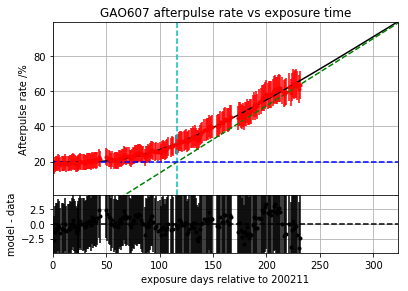

In [17]:
new_t_range = np.linspace(0, end, 1000)

#PLOT
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.errorbar(date_days[mid+1:], np.array(apulse_rates[mid+1:]), yerr=np.array(apulse_rates_err[mid+1:]),
                 fmt="r.", label="10% He")
plt.plot(new_t_range, model_day(new_t_range, *popt), 'k')
plt.plot(new_t_range, linear_days(new_t_range, popt[0], -popt[0]*popt[1]/6 + popt[2]), 'g--')
plt.axvline(popt[1]/6/3600/24, ls='--', color='c')
plt.axhline(popt[2], ls='--', color='b')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.xlim(0,end)
plt.ylim(1,99)
plt.grid()
plt.ylabel("Afterpulse rate /%")
plt.title("GAO607 afterpulse rate vs exposure time")

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
'''plt.plot(date[mid+1:], residual(np.array(apulse_rates[mid+1:]),
                                model(date[mid+1:], *popt),
                                np.array(apulse_rates_err[mid+1:])), 'k.')'''
plt.errorbar(date_days[mid+1:], np.array(apulse_rates[mid+1:])- model(date[mid+1:], *popt),
                                yerr=np.array(apulse_rates_err[mid+1:]), fmt='k.')
plt.ylim(-4.9,4.9)
plt.xlim(0,end)
plt.axhline(0,ls='--', color='k')
plt.grid()
plt.ylabel("model - data")
plt.xlabel("exposure days relative to 200211")
plt.savefig("/Users/willquinn/Desktop/pmt_output_files/summary_plots/model_extrap.png")

In [18]:
k = 980 * np.sqrt(1/4)
print(k)

490.0


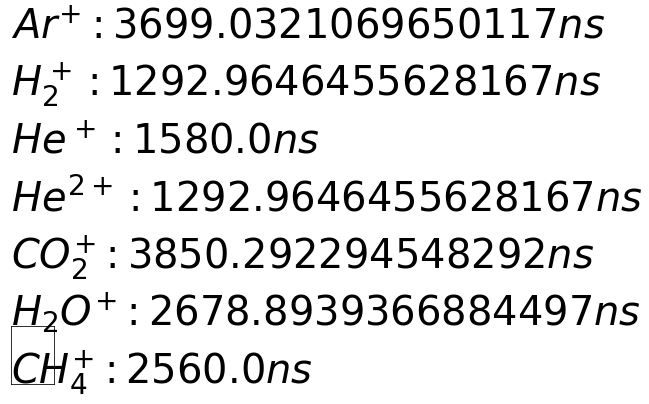

In [21]:
t_H2_1 = k * np.sqrt(2/1)
t_He_1 = k * np.sqrt(4/1)
t_He_2 = k * np.sqrt(4/2)
t_CO2_1 = k * np.sqrt(44/1)
t_H20_1 = k * np.sqrt(18/1)
t_CH4_1 = k * np.sqrt(16/1)
t_Ar_1 = k * np.sqrt(40/1)

a = "H_2^+ : " + str(t_H2_1 + 600) + ' ns'
b = "He^+ :" + str(t_He_1 + 600) + ' ns'
c = "He^{2+} :" + str(t_He_2 + 600) + ' ns'
d = "CO_2^{+} :" + str(t_CO2_1 + 600) + ' ns'
e = "H_2O^{+} :" + str(t_H20_1 + 600) + ' ns'
f = "CH_4^{+} :" + str(t_CH4_1 + 600) + ' ns'
g = "Ar^{+} :" + str(t_Ar_1 + 600) + ' ns'

ax = plt.axes([0,0,0.1,0.2])
plt.text(0,5,'$%s$' %a,size=40)
plt.text(0,4,'$%s$' %b,size=40)
plt.text(0,3,'$%s$' %c,size=40)
plt.text(0,2,'$%s$' %d,size=40)
plt.text(0,1,'$%s$' %e,size=40)
plt.text(0,0,'$%s$' %f,size=40)
plt.text(0,6,'$%s$' %g,size=40)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [20]:
V = 4*np.pi*(4*0.0254)**3/6
l = 0.001
pe = 10000
A = 4*np.pi*(4*0.0254)**2/2

L = popt[1]/6 /3600/24
D = popt[0]*l*V/pe/A
print(D,L)

1.496166544334541e-14 115.97256692443698


# Now for the He apulses

In [105]:
chi_2 = 100
n_times = 1
n = 0
for n in tqdm_notebook(range(n_times)):
    p_bounds = [[0,0,0],[1e5,1e10,10]]
    '''p0 = random.uniform(p_bounds[0][0],p_bounds[1][0])
    p1 = random.uniform(p_bounds[0][1],p_bounds[1][1])
    p2 = random.uniform(p_bounds[0][2],p_bounds[1][2])
    p3 = random.uniform(p_bounds[0][3],p_bounds[1][3])
    p4 = random.uniform(p_bounds[0][4],p_bounds[1][4])'''
    p0 = 0.1
    p1 = 1
    p2 = 5
    p_guess = [p0, p1, p2]
    
    popt_he, pcov_he = curve_fit(model, date[mid+1:], he_apulse_rates[mid+1:], sigma=he_apulse_rates_err[mid+1:], p0=p_guess,
                           bounds=p_bounds)
    chi_2 = chi2(he_apulse_rates[mid+1:], he_apulse_rates_err[mid+1:], model(date[mid+1:], *popt_he), len(popt_he))
   
    if chi_2 < 1:
        break


print('Param p{}: {:.8f} ± {:.8f}'.format(0, popt_he[0], np.sqrt(pcov_he[0,0])))
print('Param p{}: {:.9f} ± {:.9f}'.format(1, popt_he[1], np.sqrt(pcov_he[1,1])))
print('Param p{}: {:.1f} ± {:.1f}'.format(2, popt_he[2], np.sqrt(pcov_he[2,2])))
print('Chi2 is:', chi_2)


Param p0: 0.00000384 ± 0.00000002
Param p1: 43696065.602883130 ± 0.000000004
Param p2: 4.7 ± 0.1
Chi2 is: 1.9020179596175666


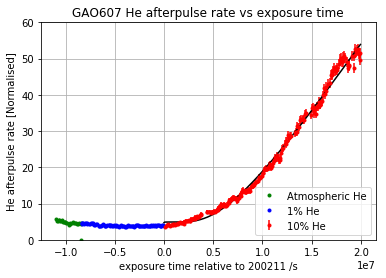

In [106]:
plt.plot(date[:start + 1], np.array(he_apulse_rates[:start + 1]),
                 "g.", label="Atmospheric He")
plt.plot(date[start+1:mid + 1], np.array(he_apulse_rates[start+1:mid + 1]),
                 "b.", label="1% He")
plt.errorbar(date[mid+1:], np.array(he_apulse_rates[mid+1:]), yerr=np.array(he_apulse_rates_err[mid+1:]),
                 fmt="r.", label="10% He")
x_range = np.linspace(0,date[-1],1000)
plt.plot(x_range, model(x_range, *popt_he), 'k')
#plt.axvline(date[start], 0, 100, ls='--', color='k')
#plt.axvline(date[mid], 0, 100, ls='--', color='k')
plt.xlabel("exposure time relative to 200211 /s")
plt.ylabel("He afterpulse rate [Normalised]")
plt.title("GAO607 He afterpulse rate vs exposure time")
plt.grid()
plt.ylim(0,60)
plt.legend(loc='lower right')
plt.savefig("/Users/willquinn/Desktop/pmt_output_files/summary_plots/model_he.png")

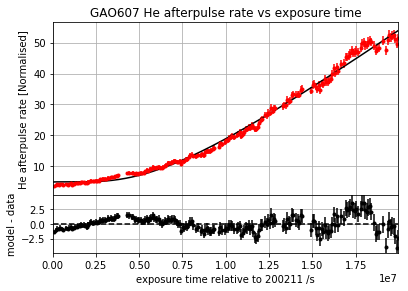

In [107]:
#PLOT
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.errorbar(date[mid+1:], np.array(he_apulse_rates[mid+1:]), yerr=np.array(he_apulse_rates_err[mid+1:]),
                 fmt="r.", label="10% He")
plt.plot(x_range, model(x_range, *popt_he), 'k')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.xlim(0,date[-1])
plt.grid()
plt.ylabel("He afterpulse rate [Normalised]")
plt.title("GAO607 He afterpulse rate vs exposure time")

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
'''plt.plot(date[mid+1:], residual(np.array(apulse_rates[mid+1:]),
                                model(date[mid+1:], *popt),
                                np.array(apulse_rates_err[mid+1:])), 'k.')'''
plt.errorbar(date[mid+1:], np.array(he_apulse_rates[mid+1:])- model(date[mid+1:], *popt_he),
                                yerr=np.array(he_apulse_rates_err[mid+1:]), fmt='k.')
plt.ylim(-4.9,4.9)
plt.xlim(0,date[-1])
plt.axhline(0,ls='--', color='k')
plt.grid()
plt.ylabel("model - data")
plt.xlabel("exposure time relative to 200211 /s")

plt.savefig("/Users/willquinn/Desktop/pmt_output_files/summary_plots/model_residual_he.png")

In [108]:
t_range = np.linspace(date[-1], date[-1]*2, 1000)

y = model(t_range, *popt_he)

for i in range(len(y)):
    if '{:.2}'.format(y[i]) == '1e+02':
        end_t = i
        break

end = (date[-1] + (end_t*date[-1]/1000)) /3600 /24
print(end, 'days')

369.59999999999997 days


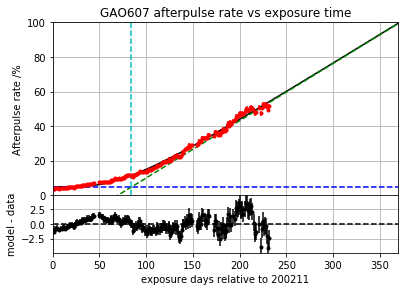

In [109]:
new_t_range = np.linspace(0, end, 1000)

#PLOT
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.errorbar(date_days[mid+1:], np.array(he_apulse_rates[mid+1:]), yerr=np.array(he_apulse_rates_err[mid+1:]),
                 fmt="r.", label="10% He")
plt.plot(new_t_range, model_day(new_t_range, *popt_he), 'k')
plt.plot(new_t_range, linear_days(new_t_range, popt_he[0], -popt_he[0]*popt_he[1]/6 + popt_he[2]), 'g--')
plt.axvline(popt_he[1]/6/3600/24, ls='--', color='c')
plt.axhline(popt_he[2], ls='--', color='b')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.xlim(0,end)
plt.ylim(0,100)
plt.grid()
plt.ylabel("Afterpulse rate /%")
plt.title("GAO607 afterpulse rate vs exposure time")

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
'''plt.plot(date[mid+1:], residual(np.array(apulse_rates[mid+1:]),
                                model(date[mid+1:], *popt),
                                np.array(apulse_rates_err[mid+1:])), 'k.')'''
plt.errorbar(date_days[mid+1:], np.array(he_apulse_rates[mid+1:])- model(date[mid+1:], *popt_he),
                                yerr=np.array(he_apulse_rates_err[mid+1:]), fmt='k.')
plt.ylim(-4.9,4.9)
plt.xlim(0,end)
plt.axhline(0,ls='--', color='k')
plt.grid()
plt.ylabel("model - data")
plt.xlabel("exposure days relative to 200211")
plt.savefig("/Users/willquinn/Desktop/pmt_output_files/summary_plots/model_he_extrap.png")

In [110]:
V = 4*np.pi*(4*0.0254)**3/6
l = 0.001
pe = 10000
A = 4*np.pi*(4*0.0254)**2/2

L = popt_he[1]/6 /3600/24
D = popt_he[0]*l*V/pe/A
print(D,L)

1.299314483764524e-14 84.29025000556159
